In [9]:
%matplotlib inline

import pickle

import dgl
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml

from matplotlib import cm
from matplotlib.ticker import LinearLocator

from src.model.get_model import get_model
from src.utils.preprocess_data import preprocess_data
from src.utils.get_target import generate_target_trajectory

# matplotlib.rcParams['font.family'] = ['Noto Serif', 'Serif']
matplotlib.rcParams['font.family'] = ['Serif']
plt.style.use('seaborn-poster')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

C:\Users\ChihyeonSong\AppData\Local\Temp\ipykernel_29992\4178649878.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


# Figure 1. Prediction Performance

findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif' not found.
findfont: Font family 'Noto Serif'

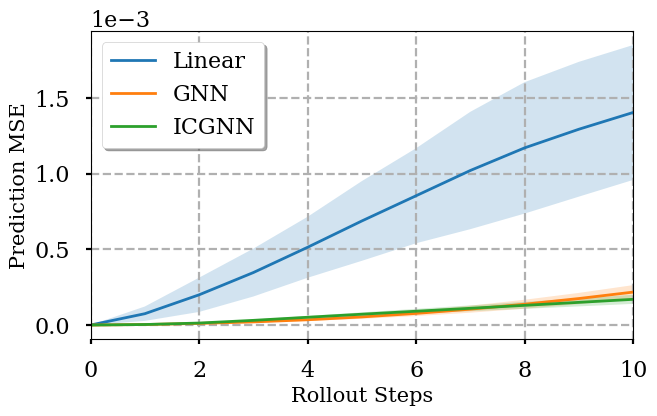

In [2]:
model_names = ['Linear', 'GNN', 'ICGNN']

# Load Data
data_generation_config = yaml.safe_load(open('config/data/data_generation_config.yaml', 'r'))
data_preprocessing_config = yaml.safe_load(open('config/data/data_preprocessing_config.yaml', 'r'))
test_data = pickle.load(open(data_generation_config['test_data_saved_path'], 'rb'))
test_config = yaml.safe_load(open('config/prediction/test_config.yaml', 'r'))

# Do Prediction Task
history_len = test_config['history_len']
receding_horizon = test_config['receding_horizon']

data_preprocessing_config['history_len'] = history_len
data_preprocessing_config['receding_horizon'] = receding_horizon
data_preprocessing_config['device'] = device
test_hist_xs, test_hist_us, test_future_us, test_future_xs, test_gs, test_idxs = preprocess_data(test_data,
                                                                                                 data_preprocessing_config)
with torch.no_grad():
    tg = dgl.batch([test_gs[idx[0]] for idx in test_idxs])
    thx = torch.cat([test_hist_xs[idx[0]][idx[1]] for idx in test_idxs])
    thu = torch.cat([test_hist_us[idx[0]][idx[1]] for idx in test_idxs])
    tfu = torch.cat([test_future_us[idx[0]][idx[1]] for idx in test_idxs])
    tfx = torch.cat([test_future_xs[idx[0]][idx[1]] for idx in test_idxs])

model_loss_dict = {}

def crit(x, y):
    loss_fn = torch.nn.SmoothL1Loss(reduction='none')
    mean = loss_fn(x, y).mean(dim=(0, 2)).detach().cpu().numpy()
    std = loss_fn(x, y).std(dim=(0, 2)).detach().cpu().numpy()
    mean = np.concatenate([[0], mean])
    std = np.concatenate([[0], std])
    return mean, std

for model_name in model_names:
    model_config = yaml.safe_load(open('config/model/{}/model_config.yaml'.format(model_name), 'r'))
    m = get_model(model_name, model_config, True).to(device)
    with torch.no_grad():
        pfx = m.multistep_prediction(tg, thx, thu, tfu)
        model_loss_dict[model_name] = crit(tfx, pfx)

# Visualize Prediction Performance

gamma = 0.1
label_size = 15
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
for model_name in model_loss_dict.keys():
    mean = model_loss_dict[model_name][0]
    std = model_loss_dict[model_name][1]
    axes.plot(mean, label=model_name, linewidth=2)
    axes.fill_between(range(mean.shape[0]),
                      mean - gamma * std,
                      mean + gamma * std, alpha=0.2)
axes.set_xlabel(r'Rollout Steps', fontsize=label_size)
axes.set_ylabel(r'Prediction MSE', fontsize=label_size)
axes.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axes.legend(fancybox=True, shadow=True)
axes.grid(True, which='both', ls='--')
axes.set_xlim(0, 10)
# fig.savefig('prediction.pdf', bbox_inches='tight')
plt.show()

# Figure 2. Heater Location Optimization Performance Loss vs # of Optimization Steps

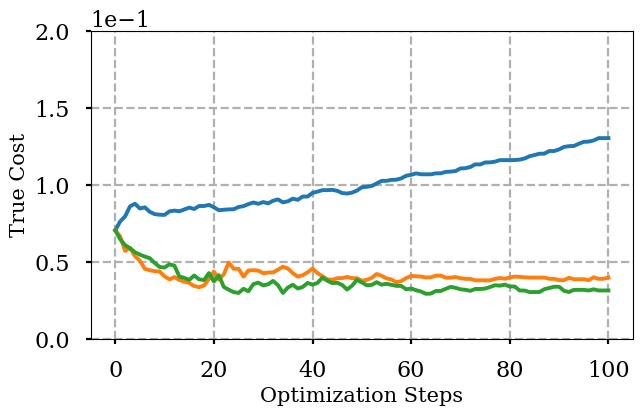

In [10]:
target = pickle.load(open('data/bilevel_design_opt/target.pkl', 'rb'))

color_dict = {
    'Linear': u'#1f77b4',
    'GAT': u'#ff7f0e',
    'ICGAT': u'#2ca02c'
}

def measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list):
    ridge_coefficient = mpc_config['ridge_coefficient']
    smoothness_coefficient = mpc_config['smoothness_coefficient']
    target_values_list = mpc_config['target_values_list']
    target_times_list = mpc_config['target_times_list']

    num_sensors = x_trajectory_list[0].shape[1]
    num_heaters = u_trajectory_list[0].shape[1]
    target_list = []
    for (target_values, target_times) in zip(target_values_list, target_times_list):
        target = np.array(generate_target_trajectory(target_values, target_times))
        target = np.reshape(target, newshape=(-1, 1))
        target = np.concatenate([target for _ in range(num_sensors)], axis=1)
        target_list.append(target)
    loss_list = []

    def compute_mpc_loss(x_traj, u_traj, target):
        loss_obj = np.square(x_traj[1:] - target).mean(axis=0).sum()
        loss_ridge = ridge_coefficient * np.square(u_traj).mean(axis=0).sum()
        u_prev = np.concatenate([np.zeros((1, num_heaters)), u_traj[:-1]], axis=0)
        loss_smoothness = smoothness_coefficient * np.square(u_traj - u_prev).mean(axis=0).sum()
        return loss_obj + loss_ridge + loss_smoothness

    for (x_traj, u_traj, target) in zip(x_trajectory_list, u_trajectory_list, target_list):
        loss_list.append(compute_mpc_loss(x_traj, u_traj, target))
    return np.array(loss_list)

num_x = 3
num_heaters = 5
model_names = ['Linear', 'GAT', 'ICGAT']

mpc_config = {
    'ridge_coefficient': 0.0,
    'smoothness_coefficient': 0.0,
    'target_values_list': target['target_values'],
    'target_times_list': target['target_times'],
    'max_iter': 200,
    'loss_threshold': 1e-9,
    'opt_config': {'lr': 2e-0},
    'scheduler_config': {'patience': 5, 'factor': 0.5, 'min_lr': 1e-4}
}

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
for model_name in model_names:
    loss_curve = []
    for i in range(101):
        true_loss_dict = pickle.load(open('bilevel_opt_result/optimal/true_loss/implicit_{}_7/{}_{}_{}.pkl'.format(model_name, num_x, num_heaters, i), 'rb'))
        x_trajectory_list = true_loss_dict['x_trajectory']
        u_trajectory_list = true_loss_dict['u_trajectory']
        log_trajectory_list = true_loss_dict['log_trajectory']
        loss_list = measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list)
        loss_curve.append(np.mean(loss_list))
    if model_name == 'Linear':
        # axes.plot(loss_curve, label='{}, True Cost'.format(model_name), color=color_dict[model_name])
        axes.plot(loss_curve, label='{}, Implicit'.format(model_name), color=color_dict[model_name])
    elif model_name == 'GAT':
        # axes.plot(loss_curve, label='{}NN, True Cost'.format(model_name[:-2]), color=color_dict[model_name])
        axes.plot(loss_curve, label='{}NN, Implicit'.format(model_name[:-2]), color=color_dict[model_name])
    else:
        # axes.plot(loss_curve, label='{}NN, True Cost'.format(model_name[:-2]), color=color_dict[model_name])
        axes.plot(1.0 * np.array(loss_curve), label='{}NN, Implicit (Ours)'.format(model_name[:-2]), color=color_dict[model_name])

# for model_name in model_names:
#     opt_result = pickle.load(open('bilevel_opt_result/implicit_{}/4_5.pkl'.format(model_name), 'rb'))
#     loss_trajectory = opt_result['opt_log']['total_loss_trajectory'][:, 8]
#     axes.plot(loss_trajectory/32, color=color_dict[model_name], linestyle='--', linewidth=3)
    # if model_name == 'Linear':
        # axes.plot(loss_trajectory/32, label='{}, Predicted Cost'.format(model_name), color=color_dict[model_name], linestyle='--', linewidth=3
    # elif model_name == 'GAT':
        # axes.plot(loss_trajectory/32, label='{}NN, Predicted Cost'.format(model_name[:-2]), color=color_dict[model_name], linestyle='--', linewidth=3)
    # else:
        # axes.plot(loss_trajectory/32, label='{}NN, Predicted Cost'.format(model_name[:-2]), color=color_dict[model_name], linestyle='--', linewidth=3)
    
    
label_size = 15

axes.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axes.set_yscale('log')
axes.ticklabel_format(axis='y', style='sci')
axes.set_ylim([0.0, 0.2])
# axes.legend(fancybox=True, shadow=True)
axes.grid(True, which='major', ls='--')
axes.set_xlabel('Optimization Steps', fontsize=label_size)
axes.set_ylabel('True Cost', fontsize=label_size)
# axes.legend(fontsize=label_size*0.9, loc=5)
plt.show()

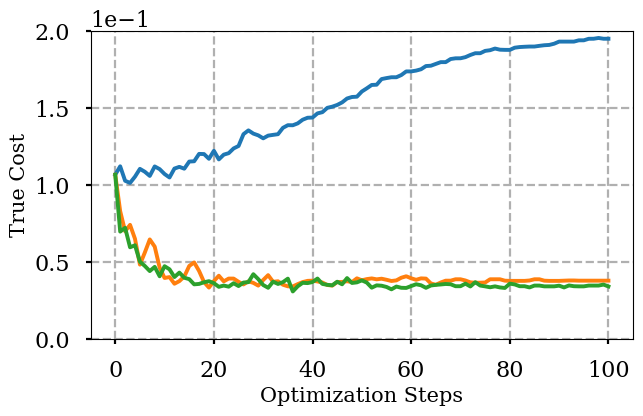

In [11]:
target = pickle.load(open('data/bilevel_design_opt/target.pkl', 'rb'))

color_dict = {
    'Linear': u'#1f77b4',
    'GAT': u'#ff7f0e',
    'ICGAT': u'#2ca02c'
}

def measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list):
    ridge_coefficient = mpc_config['ridge_coefficient']
    smoothness_coefficient = mpc_config['smoothness_coefficient']
    target_values_list = mpc_config['target_values_list']
    target_times_list = mpc_config['target_times_list']

    num_sensors = x_trajectory_list[0].shape[1]
    num_heaters = u_trajectory_list[0].shape[1]
    target_list = []
    for (target_values, target_times) in zip(target_values_list, target_times_list):
        target = np.array(generate_target_trajectory(target_values, target_times))
        target = np.reshape(target, newshape=(-1, 1))
        target = np.concatenate([target for _ in range(num_sensors)], axis=1)
        target_list.append(target)
    loss_list = []

    def compute_mpc_loss(x_traj, u_traj, target):
        loss_obj = np.square(x_traj[1:] - target).mean(axis=0).sum()
        loss_ridge = ridge_coefficient * np.square(u_traj).mean(axis=0).sum()
        u_prev = np.concatenate([np.zeros((1, num_heaters)), u_traj[:-1]], axis=0)
        loss_smoothness = smoothness_coefficient * np.square(u_traj - u_prev).mean(axis=0).sum()
        return loss_obj + loss_ridge + loss_smoothness

    for (x_traj, u_traj, target) in zip(x_trajectory_list, u_trajectory_list, target_list):
        loss_list.append(compute_mpc_loss(x_traj, u_traj, target))
    return np.array(loss_list)

num_x = 4
num_heaters = 5
model_names = ['Linear', 'GAT', 'ICGAT']

mpc_config = {
    'ridge_coefficient': 0.0,
    'smoothness_coefficient': 0.0,
    'target_values_list': target['target_values'],
    'target_times_list': target['target_times'],
    'max_iter': 200,
    'loss_threshold': 1e-9,
    'opt_config': {'lr': 2e-0},
    'scheduler_config': {'patience': 5, 'factor': 0.5, 'min_lr': 1e-4}
}

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
for model_name in model_names:
    loss_curve = []
    for i in range(101):
        true_loss_dict = pickle.load(open('bilevel_opt_result/optimal/true_loss/implicit_{}_8/{}_{}_{}.pkl'.format(model_name, num_x, num_heaters, i), 'rb'))
        x_trajectory_list = true_loss_dict['x_trajectory']
        u_trajectory_list = true_loss_dict['u_trajectory']
        log_trajectory_list = true_loss_dict['log_trajectory']
        loss_list = measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list)
        loss_curve.append(np.mean(loss_list))
    if model_name == 'Linear':
        # axes.plot(loss_curve, label='{}, True Cost'.format(model_name), color=color_dict[model_name])
        axes.plot(loss_curve, label='{}, Implicit'.format(model_name), color=color_dict[model_name])
    elif model_name == 'GAT':
        # axes.plot(loss_curve, label='{}NN, True Cost'.format(model_name[:-2]), color=color_dict[model_name])
        axes.plot(loss_curve, label='{}NN, Implicit'.format(model_name[:-2]), color=color_dict[model_name])
    else:
        # axes.plot(loss_curve, label='{}NN, True Cost'.format(model_name[:-2]), color=color_dict[model_name])
        axes.plot(1.0 * np.array(loss_curve), label='{}NN, Implicit (Ours)'.format(model_name[:-2]), color=color_dict[model_name])

# for model_name in model_names:
#     opt_result = pickle.load(open('bilevel_opt_result/implicit_{}/4_5.pkl'.format(model_name), 'rb'))
#     loss_trajectory = opt_result['opt_log']['total_loss_trajectory'][:, 8]
#     axes.plot(loss_trajectory/32, color=color_dict[model_name], linestyle='--', linewidth=3)
    # if model_name == 'Linear':
        # axes.plot(loss_trajectory/32, label='{}, Predicted Cost'.format(model_name), color=color_dict[model_name], linestyle='--', linewidth=3
    # elif model_name == 'GAT':
        # axes.plot(loss_trajectory/32, label='{}NN, Predicted Cost'.format(model_name[:-2]), color=color_dict[model_name], linestyle='--', linewidth=3)
    # else:
        # axes.plot(loss_trajectory/32, label='{}NN, Predicted Cost'.format(model_name[:-2]), color=color_dict[model_name], linestyle='--', linewidth=3)
    
    
label_size = 15

axes.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axes.set_yscale('log')
axes.ticklabel_format(axis='y', style='sci')
axes.set_ylim([0.0, 0.2])
# axes.legend(fancybox=True, shadow=True)
axes.grid(True, which='major', ls='--')
axes.set_xlabel('Optimization Steps', fontsize=label_size)
axes.set_ylabel('True Cost', fontsize=label_size)
# axes.legend(fontsize=label_size*0.9, loc=5)
plt.show()

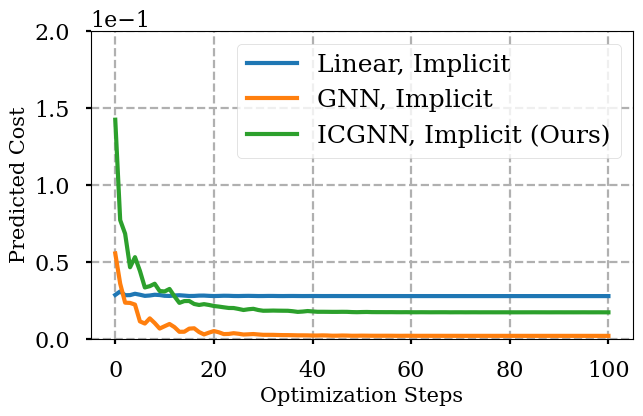

In [12]:
target = pickle.load(open('data/bilevel_design_opt/target.pkl', 'rb'))

num_x = 4
num_heaters = 5
model_names = ['Linear', 'GAT', 'ICGAT']

mpc_config = {
    'ridge_coefficient': 0.0,
    'smoothness_coefficient': 0.0,
    'target_values_list': target['target_values'],
    'target_times_list': target['target_times'],
    'max_iter': 200,
    'loss_threshold': 1e-9,
    'opt_config': {'lr': 2e-0},
    'scheduler_config': {'patience': 5, 'factor': 0.5, 'min_lr': 1e-4}
}

fig, axes = plt.subplots(1, 1, figsize=(7, 4))

for model_name in model_names:
    opt_result = pickle.load(open('bilevel_opt_result/implicit_{}/4_5.pkl'.format(model_name), 'rb'))
    loss_trajectory = opt_result['opt_log']['total_loss_trajectory'][:, 8]
    if model_name == 'Linear':
        axes.plot(loss_trajectory/32, label='Linear, Implicit', color=color_dict[model_name], linewidth=3)
    elif model_name == 'ICGAT':
        axes.plot(loss_trajectory/32, label='ICGNN, Implicit (Ours)', color=color_dict[model_name], linewidth=3)
    else:
        axes.plot(loss_trajectory/32, label='GNN, Implicit', color=color_dict[model_name], linewidth=3)
    
    
label_size = 15

axes.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axes.set_yscale('log')
axes.ticklabel_format(axis='y', style='sci')
axes.set_ylim([0.0, 0.2])
axes.legend(fancybox=True, shadow=True)
axes.grid(True, which='major', ls='--')
axes.set_xlabel('Optimization Steps', fontsize=label_size)
axes.set_ylabel('Predicted Cost', fontsize=label_size)
axes.legend(fontsize=label_size*1.2, loc=1)
plt.show()

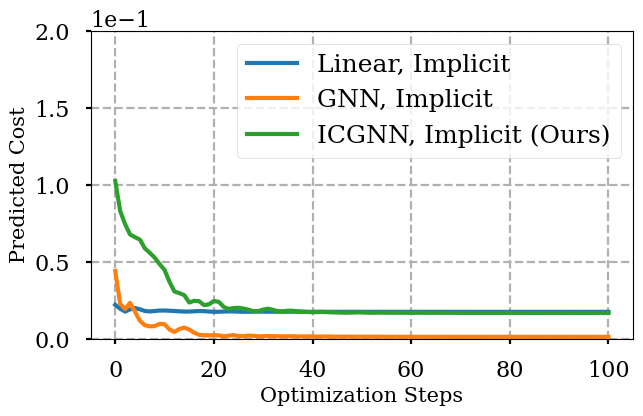

In [18]:
target = pickle.load(open('data/bilevel_design_opt/target.pkl', 'rb'))



num_x = 3
num_heaters = 5
model_names = ['Linear', 'GAT', 'ICGAT']

mpc_config = {
    'ridge_coefficient': 0.0,
    'smoothness_coefficient': 0.0,
    'target_values_list': target['target_values'],
    'target_times_list': target['target_times'],
    'max_iter': 200,
    'loss_threshold': 1e-9,
    'opt_config': {'lr': 2e-0},
    'scheduler_config': {'patience': 5, 'factor': 0.5, 'min_lr': 1e-4}
}

fig, axes = plt.subplots(1, 1, figsize=(7, 4))

for model_name in model_names:
    opt_result = pickle.load(open('bilevel_opt_result/implicit_{}/3_5.pkl'.format(model_name), 'rb'))
    loss_trajectory = opt_result['opt_log']['total_loss_trajectory'][:, 7]
    if model_name == 'Linear':
        axes.plot(loss_trajectory/32, label='Linear, Implicit', color=color_dict[model_name], linewidth=3)
    elif model_name == 'ICGAT':
        axes.plot(loss_trajectory/32, label='ICGNN, Implicit (Ours)', color=color_dict[model_name], linewidth=3)
    else:
        axes.plot(loss_trajectory/32, label='GNN, Implicit', color=color_dict[model_name], linewidth=3)
    
    
label_size = 15

axes.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axes.set_yscale('log')
axes.ticklabel_format(axis='y', style='sci')
axes.set_ylim([0.0, 0.2])
axes.legend(fancybox=True, shadow=True)
axes.grid(True, which='major', ls='--')
axes.set_xlabel('Optimization Steps', fontsize=label_size)
axes.set_ylabel('Predicted Cost', fontsize=label_size)
axes.legend(fontsize=label_size*1.2, loc=1)
plt.show()

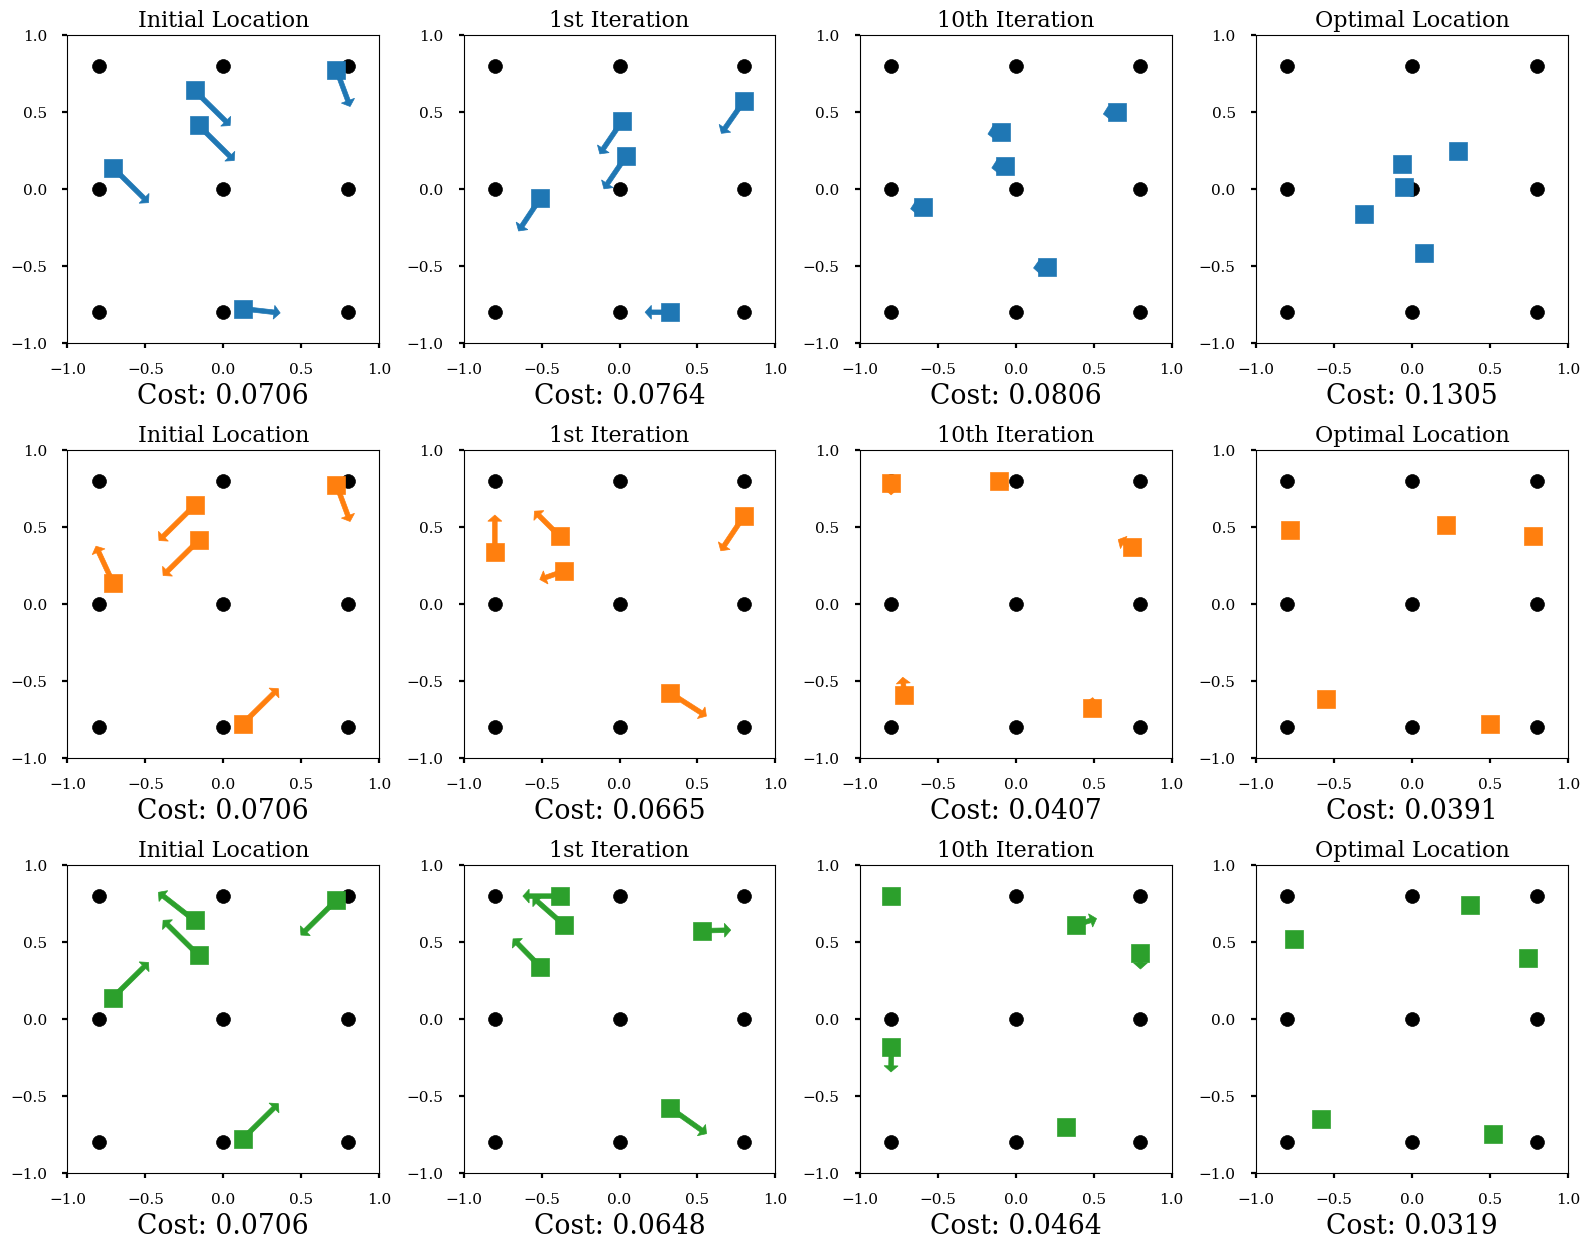

In [15]:
problem = pickle.load(open('data/bilevel_design_opt/problem_3_5.pkl', 'rb'))
state_pos = problem['state_pos'][0]
model_names = ['Linear', 'GAT', 'ICGAT']
color_dict = {
    'Linear': u'#1f77b4',
    'GAT': u'#ff7f0e',
    'ICGAT': u'#2ca02c'
}
label_size = 16
tick_size = 11
plot_idxs = [0, 1, 10]
fig, axes = plt.subplots(len(model_names), len(plot_idxs)+1, figsize=(4*(len(plot_idxs)+1), 4.2*len(model_names)))
axes_flatten = axes.flatten()
for i, model_name in enumerate(model_names):
    opt_result = pickle.load(open('bilevel_opt_result/implicit_{}/3_5.pkl'.format(model_name), 'rb'))
    position_trajectory = opt_result['opt_log']['position_trajectory'][:, 7, :, :]
    optimal_idx = np.argmin(opt_result['opt_log']['total_loss_trajectory'][:, 7])
    model_plot_idxs = plot_idxs + [optimal_idx]
    for j in range(len(model_plot_idxs)):
        true_loss_dict = pickle.load(open('bilevel_opt_result/optimal/true_loss/implicit_{}_7/3_5_{}.pkl'.format(model_name, model_plot_idxs[j]), 'rb'))
        x_trajectory_list = true_loss_dict['x_trajectory']
        u_trajectory_list = true_loss_dict['u_trajectory']
        log_trajectory_list = true_loss_dict['log_trajectory']
        loss_list = measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list)
        axes_flatten[i * len(model_plot_idxs) + j].scatter(state_pos[:, 0], state_pos[:, 1], color='black', s=100)
        axes_flatten[i * len(model_plot_idxs) + j].scatter(position_trajectory[model_plot_idxs[j], :, 0], position_trajectory[model_plot_idxs[j], :, 1], color=color_dict[model_name], s=150, marker='s')
        if j != len(model_plot_idxs)-1:
            for k in range(position_trajectory.shape[-2]):
                current_x = position_trajectory[model_plot_idxs[j], k, 0]
                current_y = position_trajectory[model_plot_idxs[j], k, 1]
                dx = position_trajectory[model_plot_idxs[j]+1, k, 0] - position_trajectory[model_plot_idxs[j], k, 0]
                dy = position_trajectory[model_plot_idxs[j]+1, k, 1] - position_trajectory[model_plot_idxs[j], k, 1]
                axes_flatten[i * len(model_plot_idxs) + j].arrow(current_x, current_y, dx, dy, color=color_dict[model_name], width=0.03, head_length=0.04)
        axes_flatten[i * len(model_plot_idxs) + j].set_xlim(-1, 1)
        axes_flatten[i * len(model_plot_idxs) + j].set_ylim(-1, 1)
        axes_flatten[i * len(model_plot_idxs) + j].set_xticks([-1, -0.5, 0, 0.5, 1])
        axes_flatten[i * len(model_plot_idxs) + j].set_yticks([-1, -0.5, 0, 0.5, 1])
        axes_flatten[i * len(model_plot_idxs) + j].tick_params(axis='both', which='major', labelsize=tick_size)
        axes_flatten[i * len(model_plot_idxs) + j].set_xlabel('Cost: {}'.format(np.around(np.mean(loss_list), 4)), fontsize=label_size*1.2)
        if j == 0:
            axes_flatten[i * len(model_plot_idxs) + j].set_title('Initial Location', fontsize=label_size)
        elif j == 1:
            axes_flatten[i * len(model_plot_idxs) + j].set_title('1st Iteration', fontsize=label_size)
        elif j == len(model_plot_idxs)-1:
            axes_flatten[i * len(model_plot_idxs) + j].set_title('Optimal Location', fontsize=label_size)
        else:
            axes_flatten[i * len(model_plot_idxs) + j].set_title('{}th Iteration'.format(plot_idxs[j]), fontsize=label_size)
fig.tight_layout()

# Figure 3. Heater Location Optimization Performance: Loss vs # of heaters

## Previous Option

In [ ]:
num_x_list = [3, 4, 5]
num_heaters_list = [5, 10, 15, 20]

fig, axes = plt.subplots(1, len(num_x_list), figsize=(4.5 * len(num_x_list), 3.5 * 1))
axes_flatten = axes.flatten()
color_dict = {
    'Linear': u'#1f77b4',
    'GAT': u'#ff7f0e',
    'ICGAT': u'#2ca02c',
    'cma_es': u'#d62728',
    'single_layer': u'#9467bd',
    'implicit': u'#2ca02c',
}
model_names = ['Linear', 'GAT', 'ICGAT']
solver_names = ['single_layer', 'cma_es', 'implicit']
label_size = 15
tick_size = 10
legend_size = 10
for i, num_x in enumerate(num_x_list):
    for model_name in model_names:
        loss_list = []
        for num_heaters in num_heaters_list:
            optimal_result = pickle.load(open('bilevel_opt_result/optimal/implicit_{}/optimal_result_{}_{}.pkl'.format(model_name, num_x, num_heaters), 'rb'))
            x_trajectory_list = optimal_result['x_trajectory_list']
            u_trajectory_list = optimal_result['u_trajectory_list']
            log_trajectory_list = optimal_result['log_trajectory_list']
            loss = measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list)
            loss_list.append(np.mean(loss))
        if model_name == 'Linear':
            label_name ='{}, Implicit'.format(model_name)
        elif model_name == 'GAT':
            label_name = '{}NN, Implicit'.format(model_name[:-2])
        else:
            label_name = '{}NN, Implicit (Ours)'.format(model_name[:-2])
        axes_flatten[i].plot(num_heaters_list, loss_list, color=color_dict[model_name], linewidth=3, label=label_name)
        axes_flatten[i].set_title('Number of Sensors: {}'.format(num_x**2), fontsize=label_size)
        axes_flatten[i].set_ylabel('True Cost', fontsize=label_size * 0.8)
        axes_flatten[i].set_xlabel('Number of Heaters', fontsize=label_size * 0.8)
        axes_flatten[i].set_xticks(num_heaters_list)
        # axes_flatten[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        axes_flatten[i].tick_params(axis='both', which='major', labelsize=tick_size)
        axes_flatten[i].set_yscale('log')

axes_flatten[i].legend(fancybox=True, shadow=True, fontsize=legend_size)
fig.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, len(num_x_list), figsize=(4 * len(num_x_list), 3 * 1))
axes_flatten = axes.flatten()
label_size = 15
tick_size = 12
legend_size = 10

for i, num_x in enumerate(num_x_list):
    for solver_name in solver_names:
        loss_list = []
        for num_heaters in num_heaters_list:
            optimal_result = pickle.load(open('bilevel_opt_result/optimal/{}_ICGAT/optimal_result_{}_{}.pkl'.format(solver_name, num_x, num_heaters), 'rb'))
            x_trajectory_list = optimal_result['x_trajectory_list']
            u_trajectory_list = optimal_result['u_trajectory_list']
            log_trajectory_list = optimal_result['log_trajectory_list']
            loss = measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list)
            loss_list.append(np.mean(loss))
        label_name = 'ICGNN, {}'.format(solver_name)
        if solver_name == 'implicit':
            label_name = 'ICGNN, {} (Ours)'.format(solver_name)
        elif solver_name == 'cma_es':
            label_name = 'ICGNN, Nested'
        else:
            label_name = 'ICGNN, Single-Layer'
        axes_flatten[i].plot(num_heaters_list, loss_list, color=color_dict[solver_name], linewidth=3, label=label_name)
        axes_flatten[i].set_title('Number of Sensors: {}'.format(num_x**2), fontsize=label_size)
        axes_flatten[i].set_ylabel('Control Loss', fontsize=label_size)
        axes_flatten[i].set_xlabel('Number of Heaters', fontsize=label_size)
        axes_flatten[i].set_xticks(num_heaters_list)
        axes_flatten[i].tick_params(axis='both', which='major', labelsize=tick_size)
        axes_flatten[i].set_yscale('log')
        
axes_flatten[-1].legend(fancybox=True, shadow=True, fontsize=legend_size)
fig.tight_layout()

## New Version

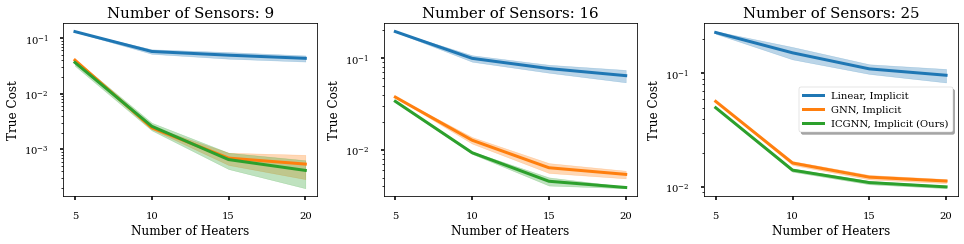

In [28]:
num_x_list = [3, 4, 5]
num_heaters_list = [5, 10, 15, 20]
num_repeats = 10

fig, axes = plt.subplots(1, len(num_x_list), figsize=(4.5 * len(num_x_list), 3.5 * 1))
axes_flatten = axes.flatten()
color_dict = {
    'Linear': u'#1f77b4',
    'GAT': u'#ff7f0e',
    'ICGAT': u'#2ca02c',
    'cma_es': u'#d62728',
    'single_layer': u'#9467bd',
    'implicit': u'#2ca02c',
}
model_names = ['Linear', 'GAT', 'ICGAT']
solver_names = ['implicit']
label_size = 15
tick_size = 10
legend_size = 10
for i, num_x in enumerate(num_x_list):
    for model_name in model_names:
        loss_list_model_mean = []
        loss_list_model_std = []
        for num_heaters in num_heaters_list:
            loss_list_repeats = []
            for j in range(num_repeats):
                optimal_result = pickle.load(open('bilevel_opt_result/optimal/implicit_{}/{}_{}_{}.pkl'.format(model_name, num_x, num_heaters, j), 'rb'))
                x_trajectory_list = optimal_result['x_trajectory_list']
                u_trajectory_list = optimal_result['u_trajectory_list']
                log_trajectory_list = optimal_result['log_trajectory_list']
                loss = measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list)
                loss_list_repeats.append(np.mean(loss))
            loss_list_model_mean.append(np.mean(loss_list_repeats))
            loss_list_model_std.append(np.std(loss_list_repeats))
        if model_name == 'Linear':
            label_name ='{}, Implicit'.format(model_name)
        elif model_name == 'GAT':
            label_name = '{}NN, Implicit'.format(model_name[:-2])
        else:
            label_name = '{}NN, Implicit (Ours)'.format(model_name[:-2])
        loss_list_model_mean = np.array(loss_list_model_mean)
        loss_list_model_std = np.array(loss_list_model_std)
        axes_flatten[i].plot(num_heaters_list, loss_list_model_mean, color=color_dict[model_name], linewidth=3, label=label_name)
        axes_flatten[i].fill_between(num_heaters_list, loss_list_model_mean - 0.5 * loss_list_model_std, loss_list_model_mean + 0.5 * loss_list_model_std, color=color_dict[model_name], alpha=0.3)
        axes_flatten[i].set_title('Number of Sensors: {}'.format(num_x**2), fontsize=label_size)
        axes_flatten[i].set_ylabel('True Cost', fontsize=label_size * 0.8)
        axes_flatten[i].set_xlabel('Number of Heaters', fontsize=label_size * 0.8)
        axes_flatten[i].set_xticks(num_heaters_list)
        # axes_flatten[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        axes_flatten[i].tick_params(axis='both', which='major', labelsize=tick_size)
        axes_flatten[i].set_yscale('log')

axes_flatten[i].legend(fancybox=True, shadow=True, fontsize=legend_size)
fig.tight_layout()
plt.show()

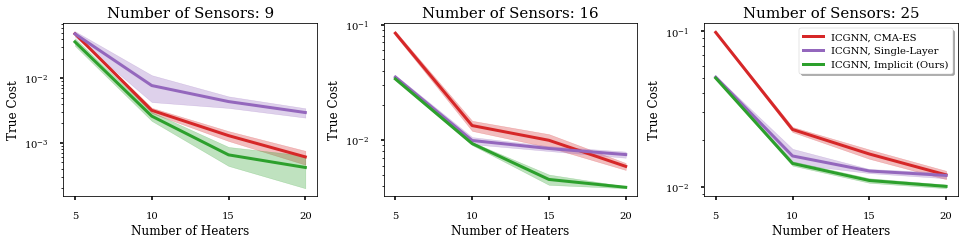

In [29]:
num_x_list = [3, 4, 5]
num_heaters_list = [5, 10, 15, 20]
num_repeats = 10

fig, axes = plt.subplots(1, len(num_x_list), figsize=(4.5 * len(num_x_list), 3.5 * 1))
axes_flatten = axes.flatten()
color_dict = {
    'Linear': u'#1f77b4',
    'GAT': u'#ff7f0e',
    'ICGAT': u'#2ca02c',
    'cma_es': u'#d62728',
    'single_layer': u'#9467bd',
    'implicit': u'#2ca02c',
}
model_names = ['ICGAT']
solver_names = ['cma_es', 'single_layer', 'implicit']
label_size = 15
tick_size = 10
legend_size = 10
for i, num_x in enumerate(num_x_list):
    for solver_name in solver_names:
        loss_list_model_mean = []
        loss_list_model_std = []
        for num_heaters in num_heaters_list:
            loss_list_repeats = []
            for j in range(num_repeats):
                optimal_result = pickle.load(open('bilevel_opt_result/optimal/{}_ICGAT/{}_{}_{}.pkl'.format(solver_name, num_x, num_heaters, j), 'rb'))
                x_trajectory_list = optimal_result['x_trajectory_list']
                u_trajectory_list = optimal_result['u_trajectory_list']
                log_trajectory_list = optimal_result['log_trajectory_list']
                loss = measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list)
                loss_list_repeats.append(np.mean(loss))
            loss_list_model_mean.append(np.mean(loss_list_repeats))
            loss_list_model_std.append(np.std(loss_list_repeats))
        if solver_name == 'cma_es':
            label_name ='ICGNN, CMA-ES'
        elif solver_name == 'single_layer':
            label_name = 'ICGNN, Single-Layer'
        else:
            label_name = 'ICGNN, Implicit (Ours)'
        loss_list_model_mean = np.array(loss_list_model_mean)
        loss_list_model_std = np.array(loss_list_model_std)
        axes_flatten[i].plot(num_heaters_list, loss_list_model_mean, color=color_dict[solver_name], linewidth=3, label=label_name)
        axes_flatten[i].fill_between(num_heaters_list, loss_list_model_mean - 0.5 * loss_list_model_std, loss_list_model_mean + 0.5 * loss_list_model_std, color=color_dict[solver_name], alpha=0.3)
        axes_flatten[i].set_title('Number of Sensors: {}'.format(num_x**2), fontsize=label_size)
        axes_flatten[i].set_ylabel('True Cost', fontsize=label_size * 0.8)
        axes_flatten[i].set_xlabel('Number of Heaters', fontsize=label_size * 0.8)
        axes_flatten[i].set_xticks(num_heaters_list)
        # axes_flatten[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        axes_flatten[i].tick_params(axis='both', which='major', labelsize=tick_size)
        axes_flatten[i].set_yscale('log')

axes_flatten[i].legend(fancybox=True, shadow=True, fontsize=legend_size)
fig.tight_layout()
plt.show()

# Figure 4. The Big Picture

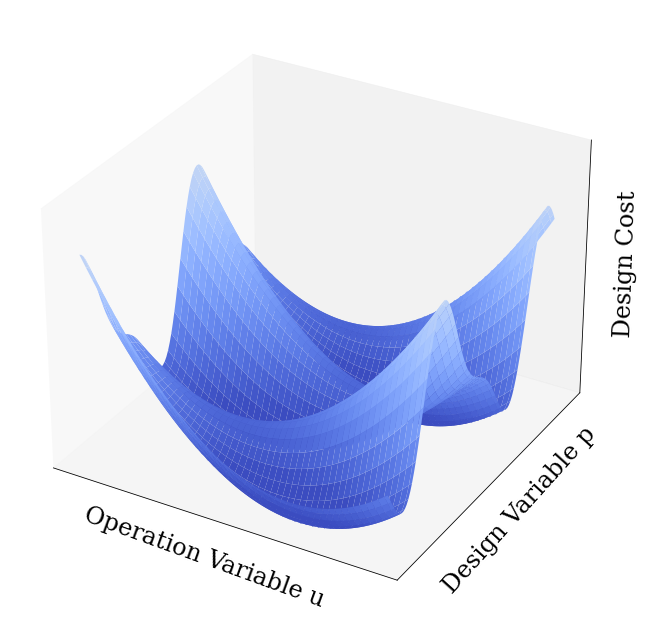

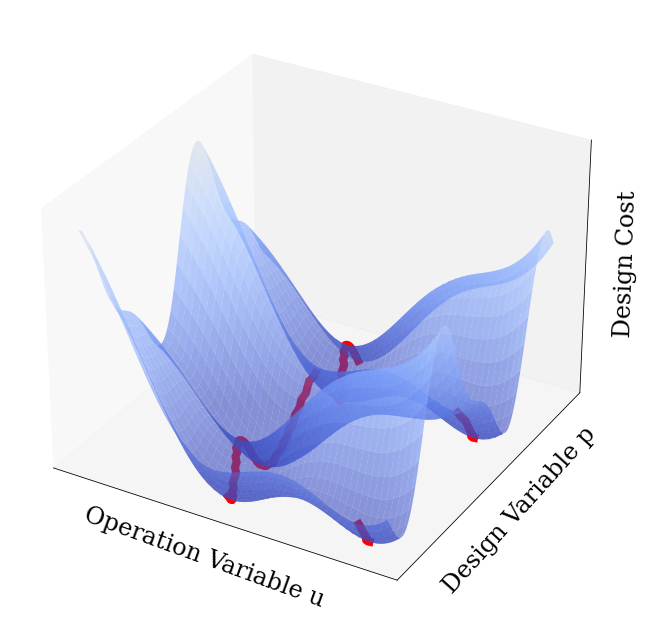

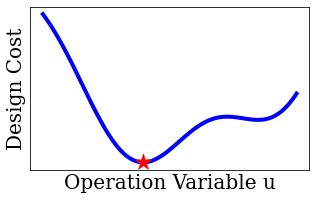

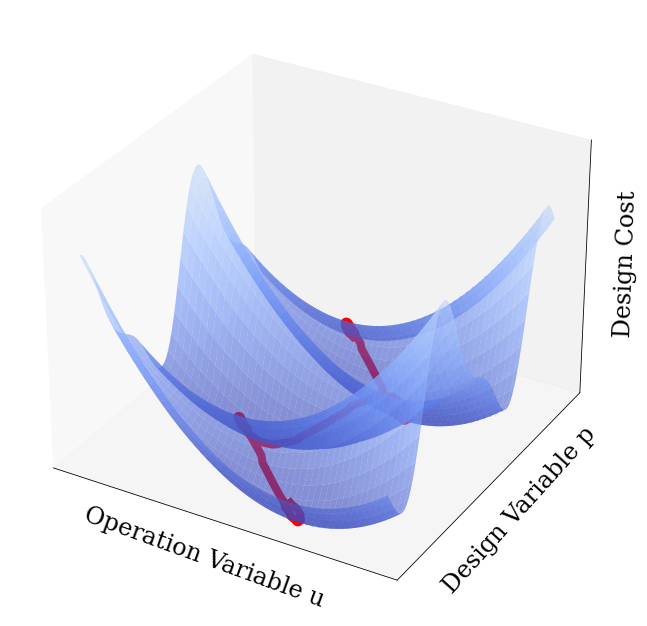

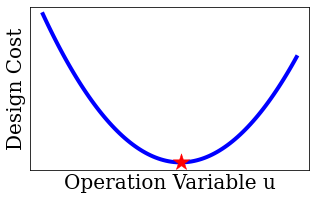

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = 5 * (X - (3 * np.sin(Y))) ** 2 + 3 * X ** 2 + np.sin(2 * Y) * 50

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, vmin=0, vmax = 1000, linewidth=0)
fontsize=24

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_zlim([0, 500])

ax.xaxis.set_rotate_label(False)
ax.xaxis.set_label_position(position='bottom')
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('Operation Variable u', fontsize=fontsize, rotation=-20)
ax.set_ylabel('Design Variable p', fontsize=fontsize, rotation=48)
ax.set_zlabel('Design Cost', fontsize=fontsize, rotation=88)
fig.tight_layout()




fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = 50 * np.sin(X) + 5 * (X - (3 * np.sin(Y))) ** 2 + 3 * X ** 2 + np.sin(2 * Y) * 50
argmin_Z = np.argmin(Z, axis=1)
min_Z = np.min(Z, axis=1)

linewidth=8
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, vmin=0, vmax = 1000, linewidth=0, alpha=0.6)
# ax.plot3D(np.arange(-5, 5, 0.1)[argmin_Z], np.arange(-5, 5, 0.1), min_Z, c='red', linewidth=5)
ax.plot3D(np.arange(-5, 5, 0.1)[argmin_Z][0:9], np.arange(-5, 5, 0.1)[0:9], min_Z[0:9], c='red', linewidth=linewidth)
ax.plot3D(np.arange(-5, 5, 0.1)[argmin_Z][9:60], np.arange(-5, 5, 0.1)[9:60], min_Z[9:60], c='red', linewidth=linewidth)
ax.plot3D(np.arange(-5, 5, 0.1)[argmin_Z][60:72], np.arange(-5, 5, 0.1)[60:72], min_Z[60:72], c='red', linewidth=linewidth)
ax.plot3D(np.arange(-5, 5, 0.1)[argmin_Z][72:], np.arange(-5, 5, 0.1)[72:], min_Z[72:], c='red', linewidth=linewidth)
fontsize=24

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_zlim([0, 500])

ax.xaxis.set_rotate_label(False)
ax.xaxis.set_label_position(position='bottom')
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('Operation Variable u', fontsize=fontsize, rotation=-20)
ax.set_ylabel('Design Variable p', fontsize=fontsize, rotation=48)
ax.set_zlabel('Design Cost', fontsize=fontsize, rotation=88)
fig.tight_layout()
plt.show()

gamma = 0.1
label_size = 20
idx = 52
best_idx = np.argmin(Z[idx])
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(Z[idx], linewidth=4, color='blue')
axes.scatter(best_idx, Z[idx, best_idx], color='red', marker='*', s=300, zorder=5)
axes.set_xlabel('Operation Variable u', fontsize=label_size)
axes.set_ylabel('Design Cost', fontsize=label_size)
axes.set_xticks([])
axes.set_yticks([])





fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = 5 * (X - (3 * np.sin(Y))) ** 2 + 3 * X ** 2 + np.sin(2 * Y) * 50
argmin_Z = np.argmin(Z, axis=1)
min_Z = np.min(Z, axis=1)

linewidth = 8
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, vmin=0, vmax = 1000, linewidth=0, alpha=0.6)
ax.plot3D(np.arange(-5, 5, 0.1)[argmin_Z], np.arange(-5, 5, 0.1), min_Z, c='red', linewidth=linewidth)
fontsize=24

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_zlim([0, 500])

ax.xaxis.set_rotate_label(False)
ax.xaxis.set_label_position(position='bottom')
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('Operation Variable u', fontsize=fontsize, rotation=-20)
ax.set_ylabel('Design Variable p', fontsize=fontsize, rotation=48)
ax.set_zlabel('Design Cost', fontsize=fontsize, rotation=88)
fig.tight_layout()
plt.show()

gamma = 0.1
label_size = 20
idx = 52
best_idx = np.argmin(Z[idx])
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(Z[idx], linewidth=4, color='blue')
axes.scatter(best_idx, Z[idx, best_idx], color='red', marker='*', s=300, zorder=10)
axes.set_xlabel('Operation Variable u', fontsize=label_size)
axes.set_ylabel('Design Cost', fontsize=label_size)
axes.set_xticks([])
axes.set_yticks([])
plt.show()

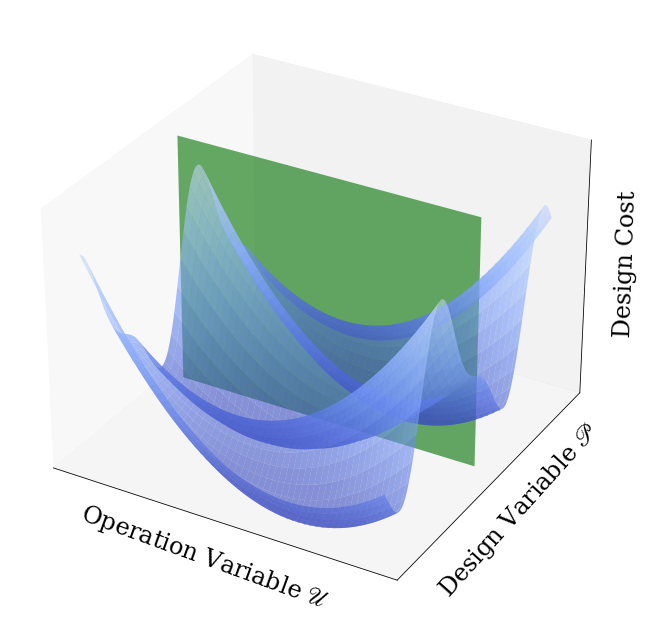

In [163]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = 5 * (X - (3 * np.sin(Y))) ** 2 + 3 * X ** 2 + np.sin(2 * Y) * 50

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, vmin=0, vmax = 1000, alpha=0.6)

_X = np.array([[-5, 5], [-5, 5]])
_Y = np.ones_like(_X) * Y[idx, idx]
_Z = np.ones_like(_X)
_Z[0] = 0
_Z[1] = 500
ax.plot_surface(_X, _Y, _Z, color='green', alpha=0.6, zorder=100)


ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_zlim([0, 500])

ax.xaxis.set_rotate_label(False)
ax.xaxis.set_label_position(position='bottom')
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('Operation Variable $\scrU$', fontsize=fontsize, rotation=-20)
ax.set_ylabel('Design Variable $\scrP$', fontsize=fontsize, rotation=48)
ax.set_zlabel('Design Cost', fontsize=fontsize, rotation=88)
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = 5 * (X - (4 * np.sin(Y))) ** 2 + 3 * X ** 2
Z = 5 * (X - (3 * np.sin(Y))) ** 2 + 3 * X ** 2 + np.sin(2 * Y) * 50
argmin_Z = np.argmin(Z, axis=1)
min_Z = np.min(Z, axis=1)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, vmin=0, vmax = 1000, linewidth=0, alpha=0.6)
ax.plot3D(np.arange(-5, 5, 0.1)[argmin_Z], np.arange(-5, 5, 0.1), min_Z, c='red', linewidth=5)
fontsize=18

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_zlim([0, 500])

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.set_xlabel('Operation Variable u', fontsize=fontsize, rotation=-20)
ax.set_ylabel('Design Variable p', fontsize=fontsize, rotation=48)
plt.show()

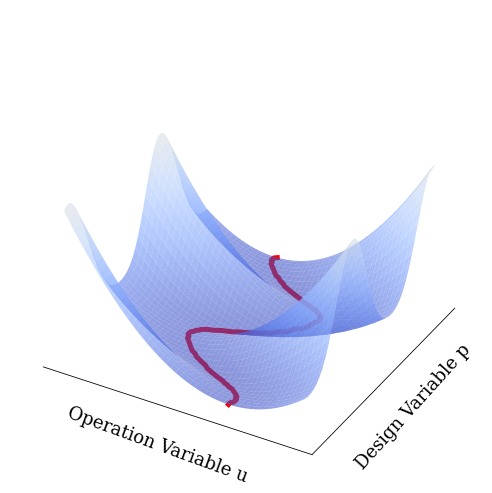

In [208]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

Z = 5 * (X - (3 * np.sin(Y))) ** 2 + 3 * X ** 2
argmin_Z = np.argmin(Z, axis=1)
min_Z = np.min(Z, axis=1)

# print(Z.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, vmin=0, vmax = 800, linewidth=0, alpha=0.6)
ax.plot3D(np.arange(-5, 5, 0.1)[argmin_Z], np.arange(-5, 5, 0.1), min_Z, c='red', linewidth=5)



fontsize=18
# Customize the z axis.
# ax.set_zlim(-1.01, 2.01)
# A StrMethodFormatter is used automatically
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
# ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_zlim([0, 500])

# ax.zaxis.set_major_formatter('{x:.02f}')
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.set_xlabel('Operation Variable u', fontsize=fontsize, rotation=-20)
ax.set_ylabel('Design Variable p', fontsize=fontsize, rotation=48)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.w_zaxis.line.set_lw(0.)
# plt.show()

# fig, axes = plt.subplots(1, 1)
# axes.plot(np.arange(-5, 5, 0.1), min_Z)
# plt.show()

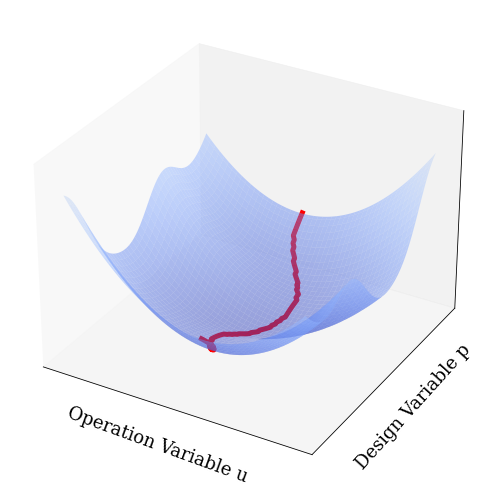

In [199]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = (X - (3 * np.sin(Y))) ** 2 + 3 * X ** 2 + 3 * Y ** 2

argmin_Z = np.argmin(Z, axis=1)
min_Z = np.min(Z, axis=1)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, vmin=0, vmax = 500, linewidth=0, alpha=0.5)# , antialiased=False)

ax.plot3D(np.arange(-5, 5, 0.1)[argmin_Z], np.arange(-5, 5, 0.1), min_Z+1, c='red', linewidth=5)
fontsize=18
# Customize the z axis.
# ax.set_zlim(-1.01, 2.01)
# A StrMethodFormatter is used automatically
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
# ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_zlim([0, 250])

# ax.zaxis.set_major_formatter('{x:.02f}')
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.set_xlabel('Operation Variable u', fontsize=fontsize, rotation=-20)
ax.set_ylabel('Design Variable p', fontsize=fontsize, rotation=48)
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.show()